<a href="https://colab.research.google.com/github/gbcarneiro/lunar-lander/blob/main/20240407_Gabriel_Carneiro_Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00


In [2]:
pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.5 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376096 sha256=8cf192e7f8f2e53f39fe9cb5184d018ed043b940188cf4705674238f77f35fbd
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [9]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random

# Adicionando hiperparâmetros
BUFFER_SIZE = int(1e5)  # tamanho do buffer de replay
BATCH_SIZE = 64         # tamanho do batch
GAMMA = 0.99            # fator de desconto
TAU = 1e-3              # parâmetro para atualização suave dos parâmetros da rede alvo
LR = 5e-4               # taxa de aprendizado
UPDATE_EVERY = 4        # frequência de atualização da rede

# Defina o dispositivo para treinamento (cuda ou cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Definindo a rede neural para Q-Learning
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size, seed):
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)
    # Definindo as camadas
    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

# Implementação do Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
      experiences = random.sample(self.memory, k=self.batch_size)

      states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
      dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

      return (states, actions, rewards, next_states, dones)  # Código para converter experiências em batches de Torch tensors vai aqui...

    def __len__(self):
        return len(self.memory)

# Implementação do Agente DQN
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
      self.state_size = state_size
      self.action_size = action_size
      self.seed = random.seed(seed)

      # Redes Q e Q fixa
      self.qnetwork_local = QNetwork(state_size, action_size, seed)
      self.qnetwork_target = QNetwork(state_size, action_size, seed)
      self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

      # Replay memory
      self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
      # Contador de tempo
      self.t_step = 0

    def update_fixed_network(self):
      """Atualiza os pesos da rede fixa Q com os pesos da rede local Q."""
      for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
        target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

    def step(self, state, action, reward, next_state, done):
        # Salvar experiência no buffer de replay
        self.memory.add(state, action, reward, next_state, done)

        # Aprender a cada UPDATE_EVERY passos de tempo
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # Se houver amostras suficientes, obter amostra aleatória do buffer de replay
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
      states, actions, rewards, next_states, dones = experiences

      # Obter Q valores máximos para próximos estados a partir da rede fixa
      Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
      # Calcular Q targets para os estados atuais
      Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

      # Obter Q valores esperados dos estados atuais da rede local
      Q_expected = self.qnetwork_local(states).gather(1, actions)

      # Computar a perda
      loss = F.mse_loss(Q_expected, Q_targets)

      # Minimizar a perda
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Atualizar os pesos da rede fixa
      self.update_fixed_network()

    def act(self, state, eps=0.0):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      self.qnetwork_local.eval()
      with torch.no_grad():
          action_values = self.qnetwork_local(state)
      self.qnetwork_local.train()

      # Selecionar ação com base na política epsilon-greedy
      if random.random() > eps:
          return np.argmax(action_values.cpu().data.numpy())
      else:
          return random.choice(np.arange(self.action_size))

# Configurações do ambiente e criação do agente
env = gym.make('LunarLander-v2')
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Criando o agente
agent = DQNAgent(state_size, action_size, seed=0)


Episódio 100	Média (últimos 100): -21.03


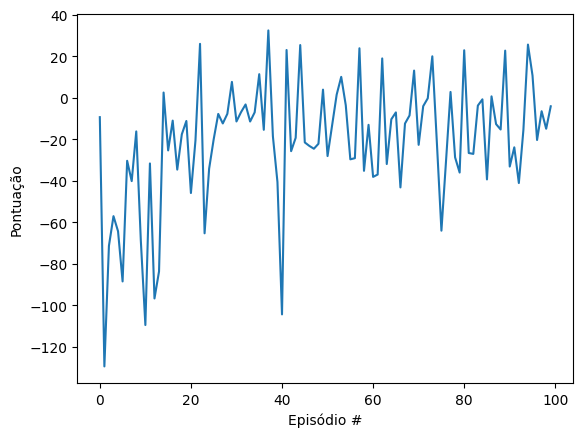

In [10]:
def train_agent(n_episodes=100, max_t=50, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Treina o agente DQN.

    Parâmetros:
        n_episodes (int): número máximo de episódios de treinamento
        max_t (int): número máximo de passos por episódio
        eps_start (float): valor inicial de epsilon para a política epsilon-greedy
        eps_end (float): valor mínimo de epsilon
        eps_decay (float): fator de decaimento de epsilon

    Retorna:
        scores (list): lista de pontuações por episódio
    """
    scores = []                        # lista para armazenar as pontuações de cada episódio
    scores_window = deque(maxlen=100)  # mantém as últimas 100 pontuações
    eps = eps_start                    # inicializa o valor de epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # salva a pontuação mais recente
        scores.append(score)              # salva a pontuação do episódio
        eps = max(eps_end, eps_decay*eps) # reduz epsilon

        print('\rEpisódio {}\tMédia (últimos 100): {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisódio {}\tMédia (últimos 100): {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nAmbiente resolvido em {:d} episódios!\tMédia (últimos 100): {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    return scores

scores = train_agent()

# Visualização do treinamento
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Pontuação')
plt.xlabel('Episódio #')
plt.show()
